In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
μReLU = [0.398942, 0.5, 0.398942, 0., -0.398942, 0.]
Eσ2ReLU = .5

μELU = [0.1605205722667549, 0.7615782918644975, 0.26157829186526865,-0.1373639885354897,-0.1373639885357776,0.2615782918541118,0.26157829187954007,-0.9352485495068876,-0.9352485493399296,5.048885656683824,5.048885656681984]
Eσ2ELU = 0.6449454174923381

def G(z,αℓ):
    """
    Stieltjes transformation of the MP distribution with ratio αℓ
    
    Parameters:
    -----------
    z : double
        argument of the function
    αℓ: double
        ratio of the MP distribution
    """
    return (1 - z - αℓ - np.sqrt((z - 1 - αℓ)**2 - 4*αℓ))/(2*z*αℓ)

def dG(z,αℓ):
    """
    Derivative of the Stieltjes transformation of the MP distribution with ratio αℓ
    
    Parameters:
    -----------
    z : double
        argument of the function
    αℓ: double
        ratio of the MP distribution
    """
    return (-z*(1 + αℓ) + (αℓ - 1)*(-1 + αℓ + np.sqrt((z - 1)**2 - 2*(1 + z)*αℓ + αℓ**2)))/(2*αℓ*z**2*np.sqrt(-4*αℓ + (1 - z + αℓ)**2))

def saddle(N,P,L,τ,step,D=30,ζ=10**(-8),yν=0.797885,yy=1,y=0,elu_relu=True,rate=0.2):
    """
    Iterative solution of the saddle-point eqs
    
    Parameters:
    -----------
    N : int
        number of random features
    P : int
        size of the training set
    L : int
        truncation of the activation function
    τ : array
        teacher's parameters, spherical Σₗ τₗ**2 = 1
    step : int
           step of the iteration 
    D : int
        input dimension
    ζ : double
        L2 regularization
    yν : double
         <yν>
    yy : double
         <y**2>
    y : double
        <y>
    elu_relu : bool
               if True ELU, else ReLU
    rate : double
           learning rate
    """
    if(step==1): # random initial conditions
        hm0_old,hq0_old,hv0_old = 5*np.random.rand(3)
        hm_old,hq_old,hv_old = 5*np.random.rand(3,L)
    else :
        m0_old,q0_old,v0_old,m_old,q_old,v_old,hm0_old,hq0_old,hv0_old,hm_old,hq_old,hv_old,Eg_old = saddle(N,P,L,τ,step-1,D,ζ,yν,yy,y,elu_relu,rate)
    
    if(elu_relu):
        μ0 = μELU[0] 
        μ = μELU[1:]
        Eσ2 = Eσ2ELU
    else :
        μ0 = μReLU[0]
        μ = μReLU[1:]
        Eσ2 = Eσ2ReLU
    
    μPerp = np.sqrt(Eσ2 - μ0**2 - np.array([μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum())
    
    α = np.array([N/math.comb(D,l) for l in range(1,L+1)])
    γ = α*np.reciprocal(hv_old)*(ζ + hv0_old)
    
    v = np.array([α[l]*(1 - γ[l]*G(-γ[l],α[l]))/hv_old[l] for l in range(0,L)])
    v0 = (1 - np.array([1 - γ[l]*G(-γ[l],α[l]) for l in range(0,L)]).sum())/(hv0_old+ζ)
    q = np.array([α[l]*(hm0_old**2 + hq0_old)/((ζ + hv0_old)*hv_old[l])*(γ[l]*G(-γ[l],α[l]) - γ[l]**2*dG(-γ[l],α[l])) + α[l]*(hm_old[l]**2 + hq_old[l])/(hv_old[l]**2)*(1 + γ[l]**2*dG(-γ[l],α[l]) - 2*γ[l]*G(-γ[l],α[l])) for l in range(0,L)])
    q0 = (hm0_old**2 + hq0_old)/(ζ + hv0_old)**2*(1 - np.array([1 - γ[l]**2*dG(-γ[l],α[l]) for l in range(0,L)]).sum())  + np.array([(hm_old[l]**2 + hq_old[l])/(hv_old[l]*(ζ+hv0_old))*(γ[l]*G(-γ[l],α[l]) - γ[l]**2*dG(-γ[l],α[l])) for l in range(0,L)]).sum()
    m = v*hm_old
    m0 = np.sqrt(N)*v0*hm0_old
    
    Vtot = μPerp**2*v0 + np.array([v[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    Qtot = μPerp**2*q0 + np.array([q[l]*μ[l]**2/(np.math.factorial(l+1)) for l in range(0,L)]).sum()
    Mtot = np.array([m[l]*τ[l+1]*μ[l]/(np.sqrt(np.math.factorial(l+1))) for l in range(0,L)]).sum()
    
    hv = rate*(np.array([P/math.comb(D,l+1)*μ[l]**2/(np.math.factorial(l+1)*(1+Vtot)) for l in range(0,L)]) ) + (1-rate)*hv_old
    hv0 = rate*(P/N*μPerp**2/(1+Vtot)) + (1-rate)*hv0_old
    hq = rate*(np.array([P/math.comb(D,l+1)*μ[l]**2/np.math.factorial(l+1)*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*Mtot + Qtot  )/(1+Vtot)**2 for l in range(0,L)]) ) + (1-rate)*hq_old
    hq0 = rate*(P/N*μPerp**2*((μ0*m0)**2 + yy - 2*μ0*m0*y - 2*yν*Mtot + Qtot  )/(1+Vtot)**2) + (1-rate)*hq0_old
    hm = rate*(np.array([P/math.comb(D,l+1)*μ[l]*τ[l+1]/np.sqrt(np.math.factorial(l+1))*yν/(1+Vtot) for l in range(0,L)])) + (1-rate)*hm_old
    hm0 = rate*(1/np.sqrt(N)*(P*μ0*y)/(P*μ0**2*v0 + (1+Vtot))) + (1-rate)*hm0_old
    
    Eg = 1/math.pi*np.arccos(Mtot/np.sqrt(Qtot))
    
    return m0,q0,v0,m,q,v,hm0,hq0,hv0,hm,hq,hv,Eg

In [3]:
Ps = np.logspace(1,5,100)
maxstep = 1000

Egs = list()
EgL1 = list()
EgL2 = list()
q0s = list()
q1s = list()
q2s = list()
v0s = list()
v1s = list()
v2s = list()
m0s = list()
m1s = list()
m2s = list()
for p in Ps:
    m0,q0,v0,m,q,v,hm0,hq0,hv0,hm,hq,hv,Eg = saddle(10**4,p,3,np.array([0,1,0,0]),maxstep)
    EgL2.append(saddle(10**4,p,2,np.array([0,1,0,0]),maxstep)[-1])
    EgL1.append(saddle(10**4,p,1,np.array([0,1,0,0]),maxstep)[-1])
    Egs.append(Eg)
    q0s.append(q0)
    q1s.append(q[0])
    q2s.append(q[1])
    v0s.append(v0)
    v1s.append(v[0])
    v2s.append(v[1])
    m0s.append(m0)
    m1s.append(m[0])
    m2s.append(m[1])

In [4]:
PsNum = pd.read_csv("data/eluDATAzeta8.csv")["P"].tolist()
EgsNum = pd.read_csv("data/eluDATAzeta8.csv")["gen"].tolist()

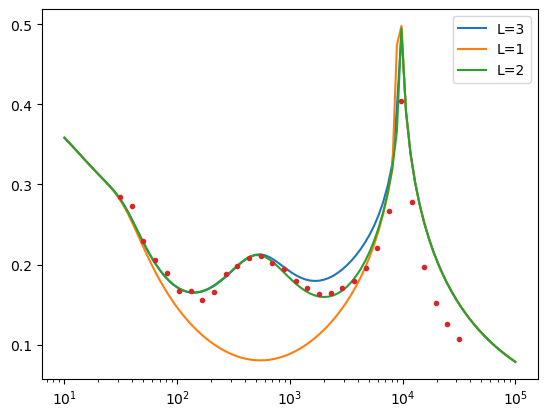

In [6]:
plt.plot(Ps,np.array(Egs),label="L=3")
plt.plot(Ps,np.array(EgL1),label="L=1")
plt.plot(Ps,np.array(EgL2),label="L=2")
plt.plot(PsNum,EgsNum,'.')
plt.xscale('log')
plt.legend()
plt.show()

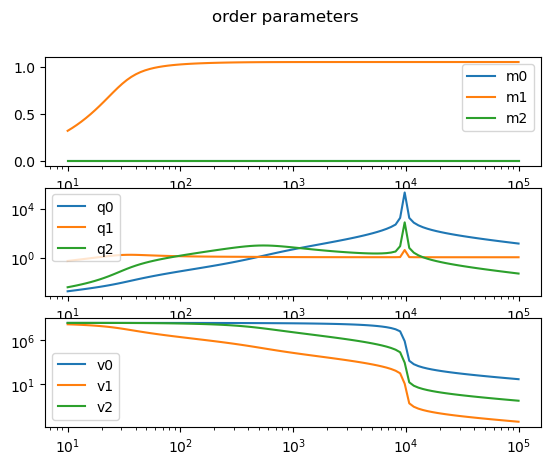

In [22]:
fig,(plM,plQ,plV) = plt.subplots(3)
fig.suptitle("order parameters")
plQ.plot(Ps,np.array(q0s),label="q0")
plQ.plot(Ps,np.array(q1s),label="q1")
plQ.plot(Ps,np.array(q2s),label="q2")
plM.plot(Ps,np.array(m0s),label="m0")
plM.plot(Ps,np.array(m1s),label="m1")
plM.plot(Ps,np.array(m2s),label="m2")
plV.plot(Ps,np.array(v0s),label="v0")
plV.plot(Ps,np.array(v1s),label="v1")
plV.plot(Ps,np.array(v2s),label="v2")
plQ.set(xscale='log',yscale='log')
plM.set(xscale='log')
plV.set(xscale='log',yscale='log')
plQ.legend()
plM.legend()
plV.legend()

In [23]:
Ps = np.logspace(1,5,100)
maxstep = 1000

T2Egs = list()
T2EgL1 = list()
T2EgL2 = list()
T2q0s = list()
T2q1s = list()
T2q2s = list()
T2v0s = list()
T2v1s = list()
T2v2s = list()
T2m0s = list()
T2m1s = list()
T2m2s = list()
for p in Ps:
    m0,q0,v0,m,q,v,hm0,hq0,hv0,hm,hq,hv,Eg = saddle(10**4,p,3,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep)
    T2EgL2.append(saddle(10**4,p,2,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep)[-1])
    T2EgL1.append(saddle(10**4,p,1,np.array([0,1/np.sqrt(2),1/np.sqrt(2),0]),maxstep)[-1])
    T2Egs.append(Eg)
    T2q0s.append(q0)
    T2q1s.append(q[0])
    T2q2s.append(q[1])
    T2v0s.append(v0)
    T2v1s.append(v[0])
    T2v2s.append(v[1])
    T2m0s.append(m0)
    T2m1s.append(m[0])
    T2m2s.append(m[1])

In [26]:
PsNum2 = pd.read_csv("data/eluDATAzeta8quad.csv")["P"].tolist()
EgsNum2 = pd.read_csv("data/eluDATAzeta8quad.csv")["gen"].tolist()

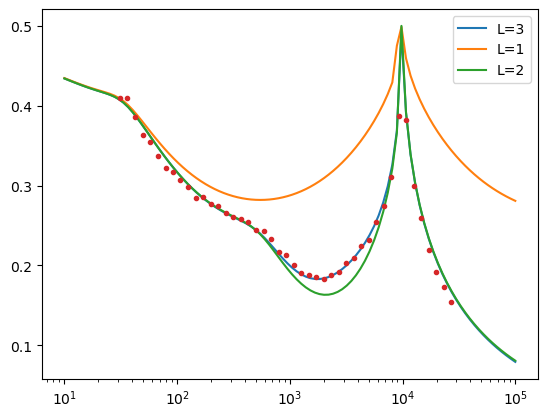

In [27]:
plt.plot(Ps,np.array(T2Egs),label="L=3")
plt.plot(Ps,np.array(T2EgL1),label="L=1")
plt.plot(Ps,np.array(T2EgL2),label="L=2")
plt.plot(PsNum2,EgsNum2,'.')
plt.xscale('log')
plt.legend()
plt.show()

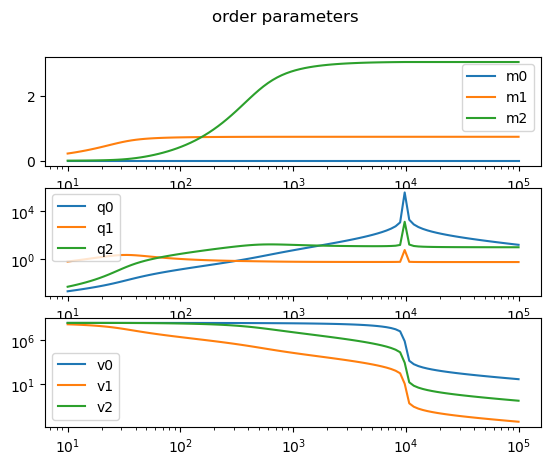

In [28]:
T2fig,(T2plM,T2plQ,T2plV) = plt.subplots(3)
T2fig.suptitle("order parameters")
T2plQ.plot(Ps,np.array(T2q0s),label="q0")
T2plQ.plot(Ps,np.array(T2q1s),label="q1")
T2plQ.plot(Ps,np.array(T2q2s),label="q2")
T2plM.plot(Ps,np.array(T2m0s),label="m0")
T2plM.plot(Ps,np.array(T2m1s),label="m1")
T2plM.plot(Ps,np.array(T2m2s),label="m2")
T2plV.plot(Ps,np.array(T2v0s),label="v0")
T2plV.plot(Ps,np.array(T2v1s),label="v1")
T2plV.plot(Ps,np.array(T2v2s),label="v2")
T2plQ.set(xscale='log',yscale='log')
T2plM.set(xscale='log')
T2plV.set(xscale='log',yscale='log')
T2plQ.legend()
T2plM.legend()
T2plV.legend()